In [1]:
import distmesh as dm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import scipy
from scipy.sparse import csr_matrix,lil_matrix
plt.rcParams.update({'font.size': 20})

count =  200 displacement =  0.012168586783411093
count =  400 displacement =  0.0034232089969463554
count =  600 displacement =  0.0037272056505444967
count =  800 displacement =  0.003385927624387421
count =  1000 displacement =  0.0026123859523727363
count =  1200 displacement =  0.0023135995093220927


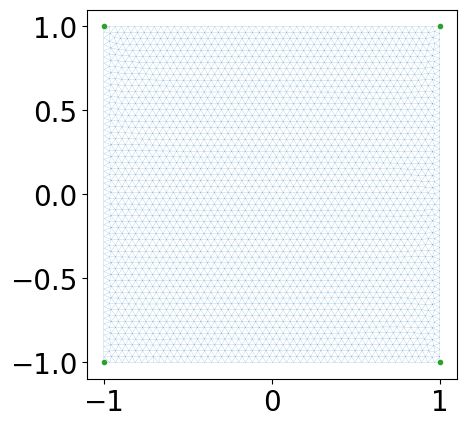

In [2]:
# Mesh code this needs to be located in the same folder as Masha's distmesh code

# dist function and fixed points in mesh
d_box = lambda p: dm.drectangle(p,-1,1,-1,1)
pfix = [[-1,-1],[-1,1],[1,-1],[1,1]]

# run distmesh
h0 = .04 # given
[pts,tri] = dm.distmesh2D(d_box, dm.huniform, h0, [-1, 1, -1, 1], pfix)
Npts,Ntri = len(pts),len(tri)

# get dirichlet and specific sides
# 'indices such that within .01 of boundary'
IDir = [i for (i,pt) in enumerate(pts) if min(abs(abs(pt[0])-1),abs(abs(pt[1])-1))<.01]
ILR  = [i for (i,pt) in enumerate(pts) if abs(abs(pt[0])-1)<.01] # left - right boundary
ITB  = [i for (i,pt) in enumerate(pts) if abs(abs(pt[1])-1)<.01] # top - bottom boundary
Ifree = [i for i in range(len(pts)) if i not in IDir]

# plot fixed points
plt.plot([p[0] for p in pfix], [p[1] for p in pfix],'.')
plt.savefig('mesh.pdf')

In [3]:
# Code for computing solution to Ginzburg-Landau equations with given initial conditions
# Adapted from Alberty et al. and https://github.com/mar1akc/transition_path_theory_FEM_distmesh/blob/main/FEM_TPT.py (Masha)

# J cost and derivative modified from Alberty et al. and Masha's code
def localj(verts,U):
    eps = 0.01
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.array([[0,0],[1,0],[0,1]])
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    Area = np.linalg.det(Aux) / 2 
    U1,U2,U3 = U[0],U[1],U[2]
    b = Area*((eps*G@G.T - (np.ones((3,3))+np.eye(3))/12)@U + \
             np.array([4*U1**3+ U2**3+U3**3+3*U1**2*(U2+U3)+2*U1 \
                *(U2**2+U3**2)+U2*U3*(U2+U3)+2*U1*U2*U3, \
                4*U2**3+ U1**3+U3**3+3*U2**2*(U1+U3)+2*U2 \
                *(U1**2+U3**2)+U1*U3*(U1+U3)+2*U1*U2*U3, \
                4*U3**3+ U2**3+U1**3+3*U3**2*(U2+U1)+2*U3 \
                *(U2**2+U1**2)+U2*U1*(U2+U1)+2*U1*U2*U3])/60)
    return b

# Derivative operator on 3 pts.
def localdj(verts,U):
    eps = 1/100
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.array([[0,0],[1,0],[0,1]])
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    Area = np.linalg.det(Aux) / 2 
    U1,U2,U3 = U[0],U[1],U[2]
    M = Area*(eps*G@G.T-(np.ones((3,3))+np.eye(3))/12 + \
            np.array([[12*U1**2+2*(U2**2+U3**2+U2*U3)+6*U1*(U2+U3),\
            3*(U1**2+U2**2)+U3**2+4*U1*U2+2*U3*(U1+U2),\
            3*(U1**2+U3**2)+U2**2+4*U1*U3+2*U2*(U1+U3)],\
            [3*(U1**2+U2**2)+U3**2+4*U1*U2+2*U3*(U1+U2),\
            12*U2**2+2*(U1**2+U3**2+U1*U3)+6*U2*(U1+U3),\
            3*(U2**2+U3**2)+U1**2+4*U2*U3+2*U1*(U2+U3)],\
            [3*(U1**2+U3**2)+U2**2+4*U1*U3+2*U2*(U1+U3),\
            3*(U2**2+U3**2)+U1**2+4*U2*U3+2*U1*(U2+U3),\
            12*U3**2+2*(U1**2+U2**2+U1*U2)+6*U3*(U1+U2)]])/60);
    return M

# Newton's iteration
def Newton(U0):
    U = U0
    for i in range(50):
        # Assembly of b - J(U), A - DJ(U)
        A = lil_matrix((Npts,Npts))
        b = np.zeros(Npts);
        for j in range(Ntri):
            v = pts[tri[j,:],:] # vertices
            ind = tri[j,:]      # indices
            indt = np.array(ind)[:,None]
            A[indt,ind] = A[indt,ind] + localdj(v,U[ind])
            b[ind] = b[ind] + localj(v,U[ind])
        # Skip Volume Forces and Neumann Boundary
        # Dirichlet conditions
        W = np.zeros(Npts);
        W[IDir] = 0;
        # Solving one Newton step
        W[Ifree] = scipy.sparse.linalg.spsolve(A[np.ix_(Ifree,Ifree)].tocsr(),b[Ifree])
        U = U - W;
        if np.linalg.norm(W) < 10**(-10):
            return U

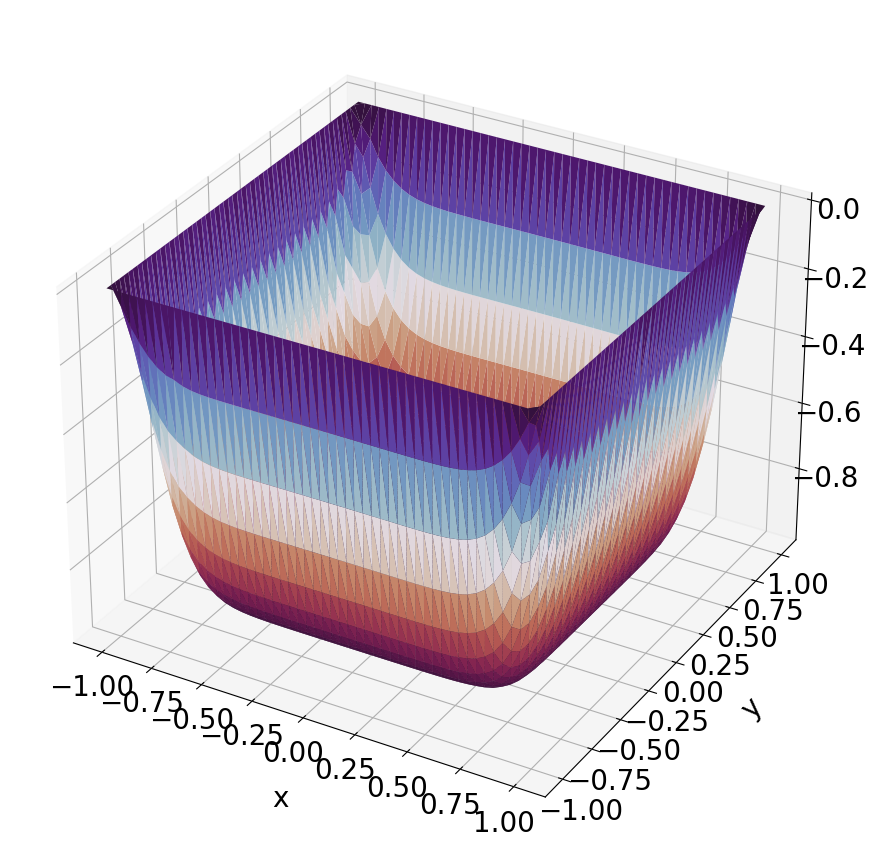

In [4]:
# initial conditions start with uD = 0
U = -np.ones(Npts)
U[IDir] = 0

U = Newton(U)

fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
ax.plot_trisurf(pts[:,0], pts[:,1], U, cmap=plt.get_cmap('twilight_shifted_r'))
plt.xlabel('\n\nx')
plt.ylabel('\n\n     y')
plt.tight_layout()
plt.savefig('Ginz_zero_init.pdf')

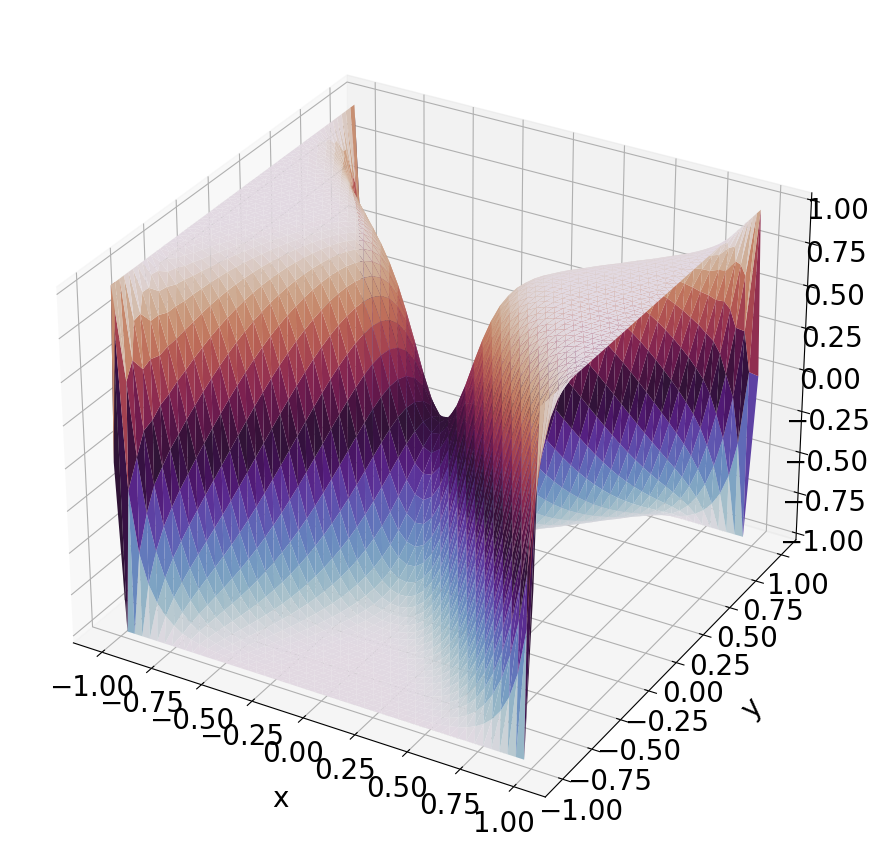

In [5]:
# initial conditions start with uD = 0
U = np.zeros(Npts)
U[ILR] += 1 # add an subtract so that corners are 0
U[ITB] -= 1

U = Newton(U)

fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
ax.plot_trisurf(pts[:,0], pts[:,1], U, cmap=plt.get_cmap('twilight'))
plt.xlabel('\n\nx')
plt.ylabel('\n\n     y')
plt.tight_layout()
plt.savefig('Ginz_mix_init.pdf')